# Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.


## Import libraries

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# We recommend to use tensorflow==1.14.0
print("TensorFlow Version {}".format(tf.__version__))

/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

TensorFlow Version 1.14.0


/home/hensden/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorboard/compat

## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [2]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
print(X_train.shape, Y_train.shape)
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

(49000, 32, 32, 3) (49000,)


## Model

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits_v2'



## Defining layers

In [3]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

# Referencing : 
# https://www.tensorflow.org/guide/variables
# https://www.tensorflow.org/api_docs/python/tf/random/truncated_normal
# https://www.tensorflow.org/api_docs/python/tf/constant
def get_w(dim):
    return tf.Variable(tf.truncated_normal(dim, stddev=0.03))

def get_b(dim):
    return tf.Variable(tf.constant(0.09, shape=dim))


def flatten(input_layer):
    # input: input tensors
    '''D = 1
    for i in input_layer.get_shape()[1:]:
        D *= i
    tf.reshape(input_layer, [-1])
    return input_layer'''
    return tf.contrib.layers.flatten(input_layer)

def fc(input_layer, num_output):
    # input: input tensors
    # num_output: int, the output dimension
    return tf.linalg.matmul(input_layer, get_w([int(input_layer.get_shape()[1]),num_output])) + get_b([num_output])


# Data Augmentation methods
# Source : https://www.tensorflow.org/tutorials/images/deep_cnn
def flip(im):
    return tf.image.random_flip_left_right(im)

def brighten(im):
    return tf.image.random_brightness(im, 0.23)

def vary(im):
    return tf.image.random_contrast(im, 0.5, 1.4)
    
# Batch Normalisation
def BN(input_layer, layer_id):
    return tf.contrib.layers.batch_norm(input_layer, scale=True,
                                        scope=layer_id)




## Sample convolutional neural network

In [4]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 64
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            # batchnorm
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        self.flat = flatten(self.pool2)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            self.fc4 = fc(self.relu3, 10)
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        self.is_train = True
        
    def _build_optimizer(self):
        S = tf.Variable(0, trainable=False)
        l0 = 5e-4
        lt = tf.train.exponential_decay(l0,decay_steps=500,global_step=S,
                                                         decay_rate=0.9,staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate=lt).minimize(loss=self.loss_op,
                                                                           global_step=S)
        
    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=labels,
                                                       logits=logits))
        
    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                feed_dict = {self.X:X_, self.Y:Y_}
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        # Graph 1. X: iteration (training step), Y: training loss
        #plt.subplot(1,2,1)
        plt.subplot(2,1,1)
        plt.title('Training loss')
        plt.xlabel('Iteration (training step)')
        plt.plot(range(len(losses)), losses, label='Loss')
        # Graph 2. X: epoch, Y: training accuracy
        #plt.subplot(1,2,2)
        plt.subplot(2,1,2)
        plt.title('Training accuracy')
        plt.xlabel('Epoch')
        plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
        # Display
        plt.gcf().set_size_inches(15, 15)
        plt.show()
        
        
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            feed_dict = {self.X:X_, self.Y:Y_}
            self.is_train = False
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter


-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
-----  Start training  -----
train for epoch 0
iteration (0): loss = 7.764, accuracy = 0.047
iteration (50): loss = 1.976, accuracy = 0.203
iteration (100): loss = 1.834, accuracy = 0.328
iteration (150): loss = 1.764, accuracy = 0.312
iteration (200): loss = 1.574, accuracy = 0

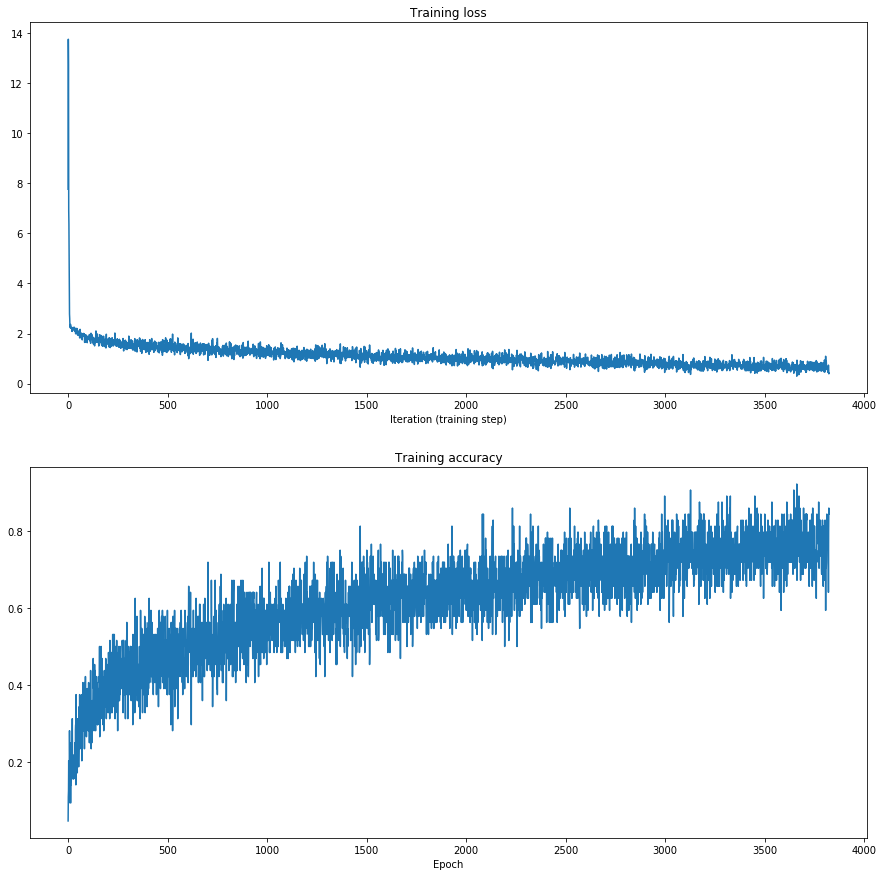

***** test accuracy: 0.636
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [5]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/GPU:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)


## Custom

For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')` and you can set your desired device number.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Batch normalization
- Dropout
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes



In [8]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 10
                            
        
        
    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        print('input layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            print('conv1 layer: ' + str(self.relu1.get_shape()))
        
        with tf.variable_scope('drop0'):
            self.drop0 = tf.nn.dropout(self.relu1, 0.69)
            
        with tf.variable_scope('bn1'):
            self.bn1 = BN(self.drop0, 'bn1')
            print('bn1 layer: ' + str(self.bn1.get_shape()))
            
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.bn1, 7, 1, 32)
            self.relu2 = tf.nn.relu(self.conv2)
            print('conv2 layer: ' + str(self.relu2.get_shape()))
            
        with tf.variable_scope('bn2'):
            self.bn2 = BN(self.relu2, 'bn2')
            print('bn2 layer: ' + str(self.bn2.get_shape()))
        
        with tf.variable_scope('pool1'):
            self.pool1 = max_pool(self.bn2,3,2)
            print('pool1 layer: ' + str(self.pool1.get_shape()))
        
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool1, 5, 1, 64)
            self.relu3 = tf.nn.relu(self.conv3)
            print('conv3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('drop1'):
            self.drop1 = tf.nn.dropout(self.relu3, 0.69)
                    
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.drop1, 5, 1, 64)
            self.relu4 = tf.nn.relu(self.conv4)
            print('conv4 layer: ' + str(self.relu4.get_shape()))
        
        with tf.variable_scope('bn3'):
            self.bn3 = BN(self.relu4, 'bn3')
            print('bn3 layer: ' + str(self.bn3.get_shape()))
            
        with tf.variable_scope('pool2'):
            self.pool2 = max_pool(self.bn3, 3, 2)
            print('pool2 layer: ' + str(self.pool2.get_shape()))
        
        with tf.variable_scope('drop2'):
            self.drop2 = tf.nn.dropout(self.pool2, 0.69)           

        self.flat = flatten(self.drop2)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc1'):
            self.fc1 = fc(self.flat, 768)
            self.relu6 = tf.nn.relu(self.fc1)
            print('fc1 layer: ' + str(self.relu6.get_shape()))
        
        with tf.variable_scope('fc2'):
            self.fc2 = fc(self.relu6, 384)
            self.relu7 = tf.nn.relu(self.fc1)
            print('fc2 layer: ' + str(self.relu7.get_shape()))
            
        with tf.variable_scope('fc3'):
            self.fc3 = fc(self.relu7, 10)
            print('fc3 layer: ' + str(self.fc3.get_shape()))
            
        # Return the last layer
        return self.fc3


'    \n    def _input_ops(self):\n        # Placeholders\n        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])\n        self.Y = tf.placeholder(tf.int64, [None])\n\n        # TODO: You can add any placeholders                                        #\n        self.is_train = True\n        \n    def _build_optimizer(self):\n        # TODO: Adam optimizer \'self.train_op\' that minimizes \'self.loss_op\'        #\n        S = tf.Variable(0, trainable=False)\n        l0 = 5e-4\n        lt = tf.train.exponential_decay(l0,decay_steps=500,global_step=S,\n                                        decay_rate=0.9,staircase=True)\n        self.train_op = tf.train.AdamOptimizer(learning_rate=lt).minimize(loss=self.loss_op,\n                                                                           global_step=S)\n        \n    def _loss(self, labels, logits):\n        # TODO: Softmax cross entropy loss \'self.loss_op\'                           #\n        self.loss_op = tf.reduce_mean(tf.

-----  Your model  -----
input layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
bn1 layer: (?, 32, 32, 32)
conv2 layer: (?, 32, 32, 32)
bn2 layer: (?, 32, 32, 32)
pool1 layer: (?, 16, 16, 32)
conv3 layer: (?, 16, 16, 64)
conv4 layer: (?, 16, 16, 64)
bn3 layer: (?, 16, 16, 64)
pool2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc1 layer: (?, 768)
fc2 layer: (?, 768)
fc3 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 3.250, accuracy = 0.031
iteration (50): loss = 1.910, accuracy = 0.203
iteration (100): loss = 1.780, accuracy = 0.422
iteration (150): loss = 1.592, accuracy = 0.406
iteration (200): loss = 1.450, accuracy = 0.531
iteration (250): loss = 1.502, accuracy = 0.438
iteration (300): loss = 1.491, accuracy = 0.422
iteration (350): loss = 1.425, accuracy = 0.438
iteration (400): loss = 1.299, accuracy = 0.500
iteration (450): loss 

iteration (2900): loss = 0.677, accuracy = 0.734
iteration (2950): loss = 0.613, accuracy = 0.750
iteration (3000): loss = 0.638, accuracy = 0.797
iteration (3050): loss = 0.453, accuracy = 0.922
validation for epoch 3
-  epoch 3: validation accuracy = 0.751
train for epoch 4
iteration (3100): loss = 0.395, accuracy = 0.891
iteration (3150): loss = 0.493, accuracy = 0.828
iteration (3200): loss = 0.692, accuracy = 0.766
iteration (3250): loss = 0.535, accuracy = 0.797
iteration (3300): loss = 0.425, accuracy = 0.891
iteration (3350): loss = 0.543, accuracy = 0.828
iteration (3400): loss = 0.751, accuracy = 0.719
iteration (3450): loss = 0.491, accuracy = 0.766
iteration (3500): loss = 0.486, accuracy = 0.812
iteration (3550): loss = 0.734, accuracy = 0.719
iteration (3600): loss = 0.615, accuracy = 0.781
iteration (3650): loss = 0.651, accuracy = 0.781
iteration (3700): loss = 0.422, accuracy = 0.844
iteration (3750): loss = 0.393, accuracy = 0.891
iteration (3800): loss = 0.262, accur

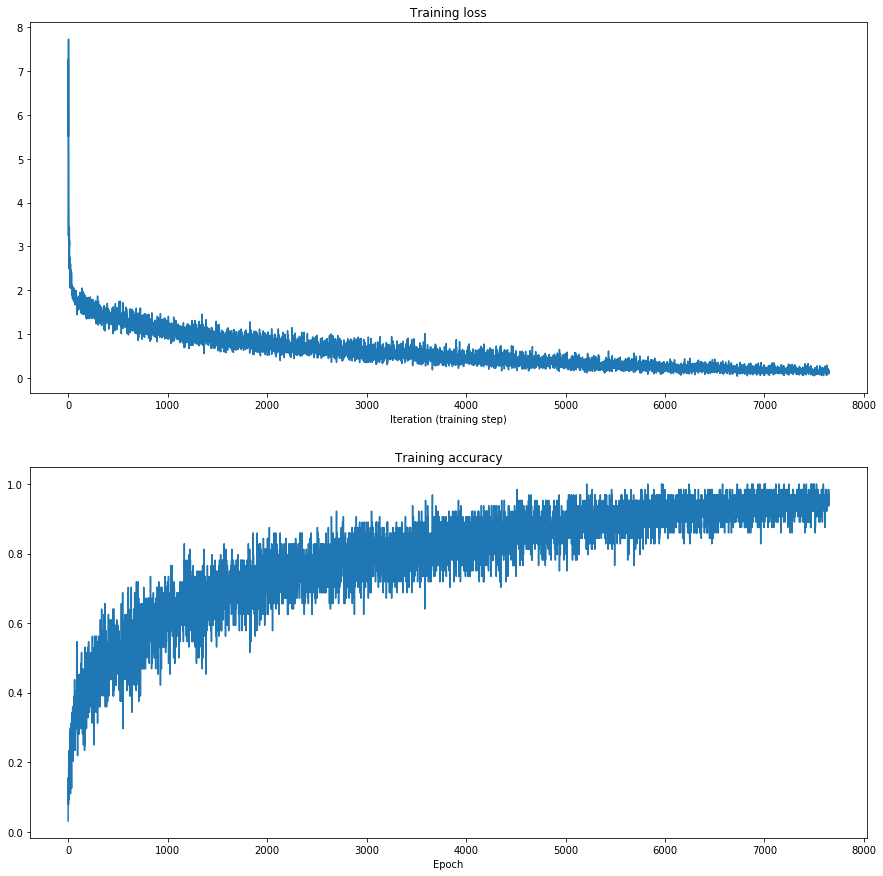

***** test accuracy: 0.763
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [9]:
# Clear old computation graphs
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/GPU:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [10]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
input layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
bn1 layer: (?, 32, 32, 32)
conv2 layer: (?, 32, 32, 32)
bn2 layer: (?, 32, 32, 32)
pool1 layer: (?, 16, 16, 32)
conv3 layer: (?, 16, 16, 64)
conv4 layer: (?, 16, 16, 64)
bn3 layer: (?, 16, 16, 64)
pool2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc1 layer: (?, 768)
fc2 layer: (?, 768)
fc3 layer: (?, 10)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
